<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2020 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import os

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [3]:
def save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/temporal/' ):
    for i in range(len(skills_ratings)):
        for j in range(i + 1, len(skills_ratings)):
            #Eligo dos números entre 0 y  de n_skills-1
            skill_1 = skills_ratings[i]
            skill_2 = skills_ratings[j]

            kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                                        mode='markers',
                                        text=df_n.loc[:,'team_position'], # 'height', 'weight', 'club', 'age', 'short_name', 'position'
                                        marker=dict(
                                            size=5,
                                            color = clusters.astype(np.float), #set color equal to a variable
                                            colorscale='Portland',
                                            showscale=False)
                                       )

            crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                                  text=df_n.loc[bool_crack,'short_name'],
                                  textfont=dict(family='sans serif',size=10,color='black'),
                                  opacity=0.9,mode='text')

            data=[kmean_clusters,crack]

            layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                            xaxis=dict(title=skill_1),
                            yaxis=dict(title=skill_2),
                            autosize=False, width=1000,height=1000)

            fig = go.Figure(data=data, layout=layout)

            file_path = folder_path + '{}_vs_{}.png'.format(skill_1, skill_2)
            if not os.path.exists(file_path):
                #iplot(fig)
                fig.write_image(file_path)
                


## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [4]:
df=pd.read_csv("players_20.csv")
df.describe()
null_columns = df.columns[df.isnull().any()]
null_columns.to_list()

['release_clause_eur',
 'player_tags',
 'team_position',
 'team_jersey_number',
 'loaned_from',
 'joined',
 'contract_valid_until',
 'nation_position',
 'nation_jersey_number',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_reflexes',
 'gk_speed',
 'gk_positioning',
 'player_traits',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm',
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm',
 'rwb',
 'lb',
 'lcb',
 'cb',
 'rcb',
 'rb']

In [5]:
df.isna().sum()

sofifa_id                         0
player_url                        0
short_name                        0
long_name                         0
age                               0
dob                               0
height_cm                         0
weight_kg                         0
nationality                       0
club                              0
overall                           0
potential                         0
value_eur                         0
wage_eur                          0
player_positions                  0
preferred_foot                    0
international_reputation          0
weak_foot                         0
skill_moves                       0
work_rate                         0
body_type                         0
real_face                         0
release_clause_eur             1298
player_tags                   16779
team_position                   240
team_jersey_number              240
loaned_from                   17230
joined                      

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [6]:
n = 10000  # cantidad de jugadores a considerar

df_n = df.loc[:n]  # se reduce la base a los n primeros jugadores

df_n = df_n[(df_n.overall > 70)]

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]
df_skills.isna().sum()



40 variables numéricas de desempeño según habilidad


attacking_crossing               0
attacking_finishing              0
attacking_heading_accuracy       0
passing                        440
attacking_short_passing          0
attacking_volleys                0
dribbling                      440
skill_dribbling                  0
skill_curve                      0
skill_fk_accuracy                0
skill_ball_control               0
movement_acceleration            0
movement_sprint_speed            0
movement_agility                 0
movement_reactions               0
movement_balance                 0
power_shot_power                 0
power_jumping                    0
power_stamina                    0
power_strength                   0
power_long_shots                 0
mentality_aggression             0
mentality_interceptions          0
mentality_positioning            0
mentality_vision                 0
mentality_penalties              0
mentality_composure              0
defending_marking                0
defending_standing_t

### Se decide sacar del analisis los skills gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes debido a que el 80% es null

In [10]:
skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 
                  'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad')

# Para no perder informacion se reemplazán los valores nulos por el promedio.
df_n = df_n.fillna(df_n.mean())

df_skills =df_n[skills_ratings]

35 variables numéricas de desempeño según habilidad


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [11]:
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn import decomposition

# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  12192108.994623316


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

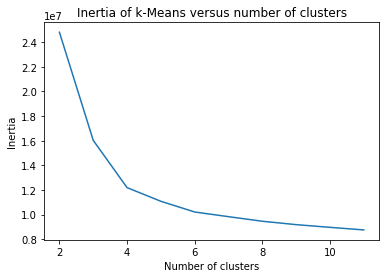

In [12]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [13]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]

'''
'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 
                  'goalkeeping_handling', 'goalkeeping_kicking',
                  'goalkeeping_positioning', 'goalkeeping_reflexes',]
print(len(skills_ratings), 'variables numéricas de desempeño según habilidad'
'''

kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                            mode='markers',
                            text=df_n.loc[:,'team_position'],
                            marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'team_position'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means - K = {} ".format(n_clust),titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [14]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


In [15]:
save_skills_graph(skills_ratings, clusters, bool_crack, folder_path='imagenes/imagenes_2020_k_means/' )

In [16]:
df_skills

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,88,95,70,92.000000,92,88,96.000000,97,93,94,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,84,94,89,82.000000,83,87,89.000000,89,81,76,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,87,87,62,87.000000,87,87,95.000000,96,88,87,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,13,11,15,66.083874,43,13,70.320667,12,13,14,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,81,84,61,86.000000,89,83,94.000000,95,83,79,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,58,70,54,65.000000,68,59,69.000000,64,62,41,73,62,71,72,75,78,58,44,52,54,68,60,65,74,71,55,76,34,52,46,12,12,16,7,8
4752,57,71,66,62.000000,64,75,73.000000,74,67,68,75,66,62,67,73,57,73,64,65,79,70,60,37,65,66,70,71,18,33,36,8,8,10,12,12
4753,70,53,61,70.000000,70,51,68.000000,69,70,53,68,60,57,67,69,64,71,63,77,68,64,83,65,65,68,61,69,69,71,65,10,7,12,13,8
4754,58,54,68,62.000000,66,50,67.000000,67,49,53,69,62,66,64,70,65,70,61,73,77,64,71,72,56,65,61,69,71,73,72,6,10,9,11,7


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


In [17]:
df_n['group_label'] = km.labels_
df_cluster_count = df_n.groupby(by=['group_label']).count()[['sofifa_id']]
df_cluster_count.columns = ['observaciones']
df_cluster_count

,observaciones
group_label,
0,1659
1,440
2,923
3,1734


In [18]:
df_n.columns.to_list()

['sofifa_id',
 'player_url',
 'short_name',
 'long_name',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'nationality',
 'club',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'player_positions',
 'preferred_foot',
 'international_reputation',
 'weak_foot',
 'skill_moves',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'team_position',
 'team_jersey_number',
 'loaned_from',
 'joined',
 'contract_valid_until',
 'nation_position',
 'nation_jersey_number',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_reflexes',
 'gk_speed',
 'gk_positioning',
 'player_traits',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_re

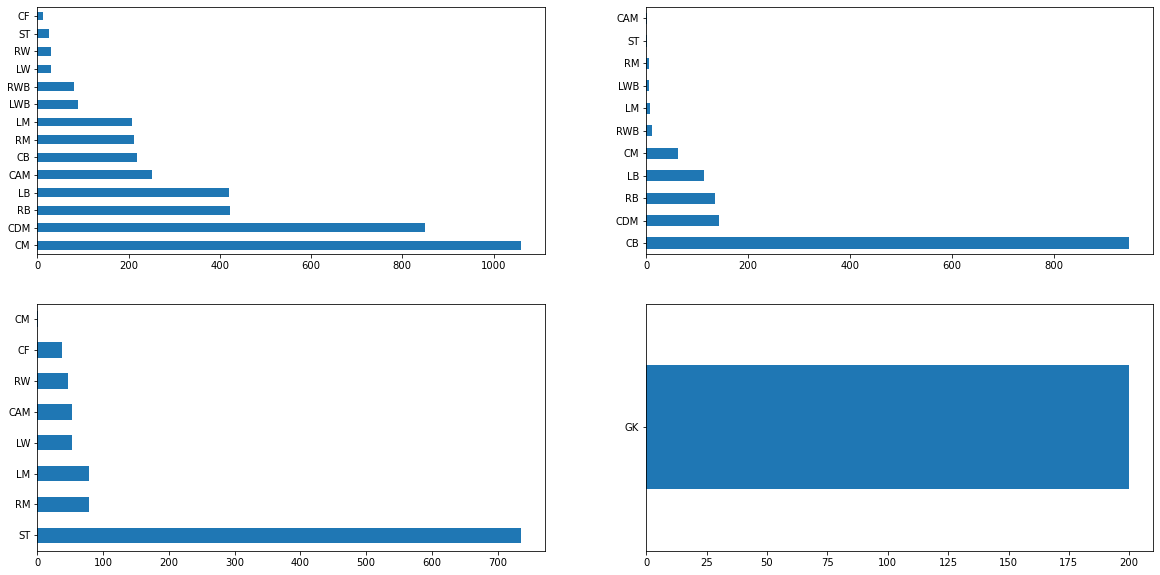

In [95]:
def player_positions_series_from_group( df, group_label, col_position = 'player_positions' ):
    array=[]
    group = df[df.group_label == group_label]
    for x in group[col_position]:
        array.extend(x.split(', '))    
    return pd.Series(array)

fig, axs = plt.subplots(2, 2, figsize=(40, 30), sharey=False)
player_positions_series_from_group(df_n, 0).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][0] )
player_positions_series_from_group(df_n, 1).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[0][1] )
player_positions_series_from_group(df_n, 2).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][0] )
player_positions_series_from_group(df_n, 3).value_counts().plot(kind='barh', figsize=(20,10), ax=axs[1][1] )


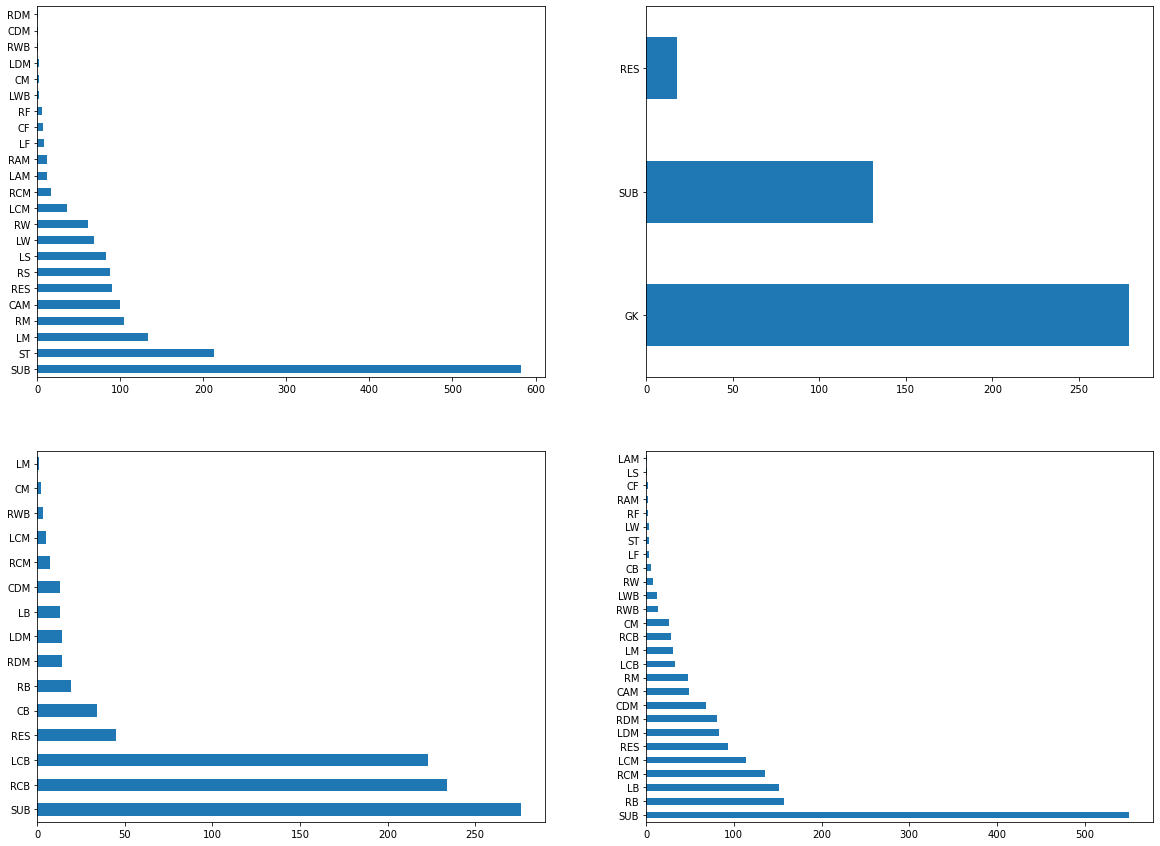

In [20]:
def get_colum_series_by_group(df, column_name, group_label):
    return df[df.group_label == group_label][column_name]

column = 'team_position'
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharey=False)

get_colum_series_by_group(df_n, column, 0).value_counts().plot(kind='barh',ax=axs[0][0])
get_colum_series_by_group(df_n, column, 1).value_counts().plot(kind='barh',ax=axs[0][1])
get_colum_series_by_group(df_n, column, 2).value_counts().plot(kind='barh',ax=axs[1][0])
get_colum_series_by_group(df_n, column, 3).value_counts().plot(kind='barh',ax=axs[1][1])


# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [21]:
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [22]:
n_samples = len(df_skills)
#bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=n_samples)
X = StandardScaler().fit_transform(df_skills)
#scaler = scaler.fit(df_skills)
#scaler.transform(df_skills)
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=n_samples)
bandwidth

4.817158601624554

In [38]:


ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters


Numero estimado de clusters para Mean Shift : 1


In [39]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
#skill_1=skills_ratings[5]
#skill_2=skills_ratings[14]
skill_1=skills_ratings[skills_ratings.index('skill_dribbling')]
skill_2=skills_ratings[skills_ratings.index('skill_ball_control')]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [40]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  1 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

Cantidad de observaciones por Cluster

Análisis descriptivo separando por Cluster

Tabla de contingencia alguna categórica vs clusters

Silohuette?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [43]:
df_n.head(5)

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,...,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,...,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,...,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,"Flair, Acrobatic Clearance",13,11,15,43,13,12,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,"Beat Offside Trap, Selfish

In [97]:
n=10000

df_n=df.loc[:n]
df_n=df_n[(df_n["team_position"]!='GK')&(df_n['overall']>69)]

#skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

skills_ratings = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'passing', 'attacking_short_passing', 'attacking_volleys', 'dribbling',
                  'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_ball_control', 'movement_acceleration',
                  'movement_sprint_speed', 'movement_agility', 'movement_reactions',
                  'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
                  'power_strength', 'power_long_shots', 'mentality_aggression',
                  'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties',  'mentality_composure', 'defending_marking',
                  'defending_standing_tackle', 'defending_sliding_tackle',
                  ]

df_skills=df_n[skills_ratings]
df_skills = df_skills.fillna(df_skills.mean())
df_skills.isna().sum()

df_n[df_n['team_position'] == 'GK']

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb


In [88]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills_kmean)

# Recuperacion de etiquetas
clusters = km.labels_


In [89]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [90]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition


ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)


Numero de clusters encontrado por Mean Shift : 8


In [91]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [92]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**

In [93]:
df_clusters

,attacking_crossing,attacking_finishing,attacking_heading_accuracy,passing,attacking_short_passing,attacking_volleys,dribbling,skill_dribbling,skill_curve,skill_fk_accuracy,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,kmeans,MeanShift
0,88,95,70,92.0,92,88,96.0,97,93,94,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,4,4
1,84,94,89,82.0,83,87,89.0,89,81,76,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,4,4
2,87,87,62,87.0,87,87,95.0,96,88,87,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,4,4
4,81,84,61,86.0,89,83,94.0,95,83,79,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,4,4
5,93,82,55,92.0,92,82,86.0,86,85,83,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,45,51,61,60.0,67,50,65.0,65,49,47,69,56,55,53,68,52,69,65,90,74,65,82,70,66,65,53,69,65,67,66,0,2
5654,68,60,46,66.0,69,49,70.0,69,55,60,70,84,83,82,62,67,66,56,69,61,55,34,21,63,65,59,62,50,29,34,4,6
5655,63,64,51,64.0,64,58,75.0,72,71,44,77,84,77,89,62,86,70,58,76,60,61,56,22,62,65,55,69,22,23,17,4,4
5656,62,53,48,68.0,71,48,74.0,72,68,62,74,74,72,80,67,82,73,69,82,81,59,75,55,57,69,57,67,55,64,55,0,0


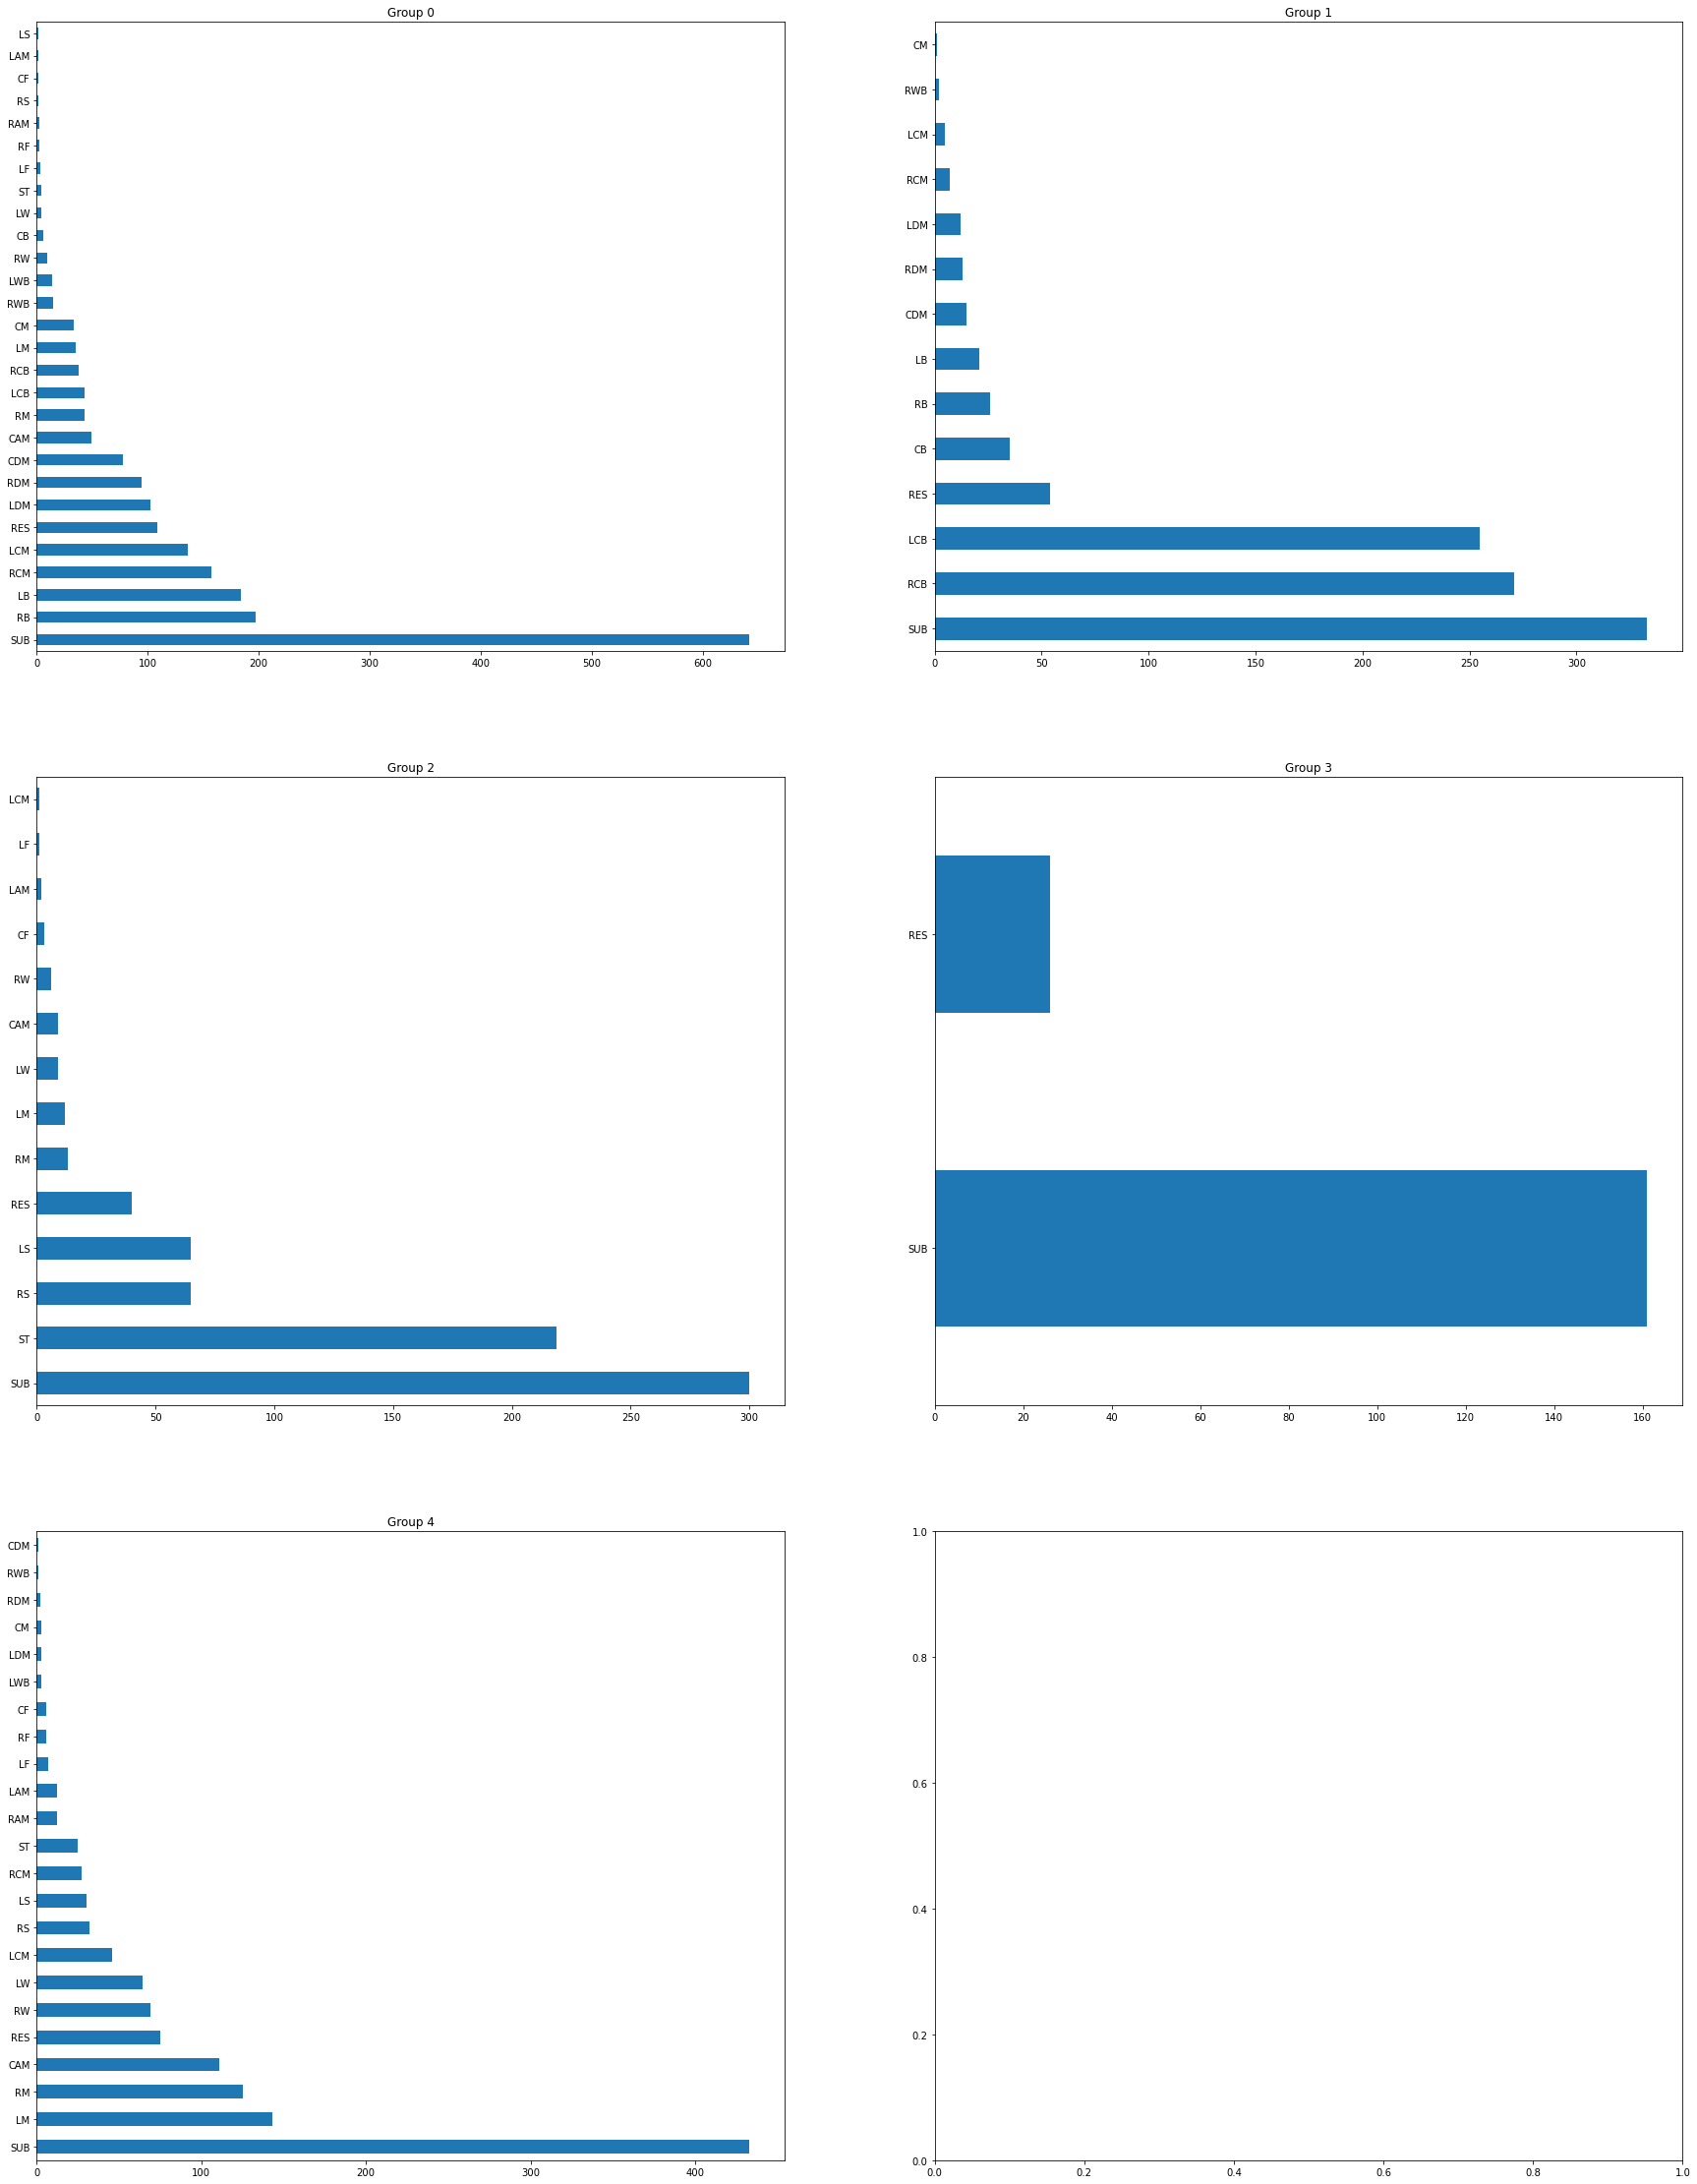

In [128]:
df_kmean = df_n
df_kmean['group_label'] = km.labels_
column_name = 'team_position'
fig, axs = plt.subplots(3, 2, figsize=(30, 40), sharey=False)
get_colum_series_by_group(df_kmean, column_name, 0).value_counts().plot(kind='barh', title='Group 0', ax=axs[0][0] )
get_colum_series_by_group(df_kmean, column_name, 1).value_counts().plot(kind='barh', title='Group 1', ax=axs[0][1] )
get_colum_series_by_group(df_kmean, column_name, 2).value_counts().plot(kind='barh', title='Group 2', ax=axs[1][0] )
get_colum_series_by_group(df_kmean, column_name, 3).value_counts().plot(kind='barh', title='Group 3', ax=axs[1][1] )
get_colum_series_by_group(df_kmean, column_name, 4).value_counts().plot(kind='barh', title='Group 4', ax=axs[2][0] )

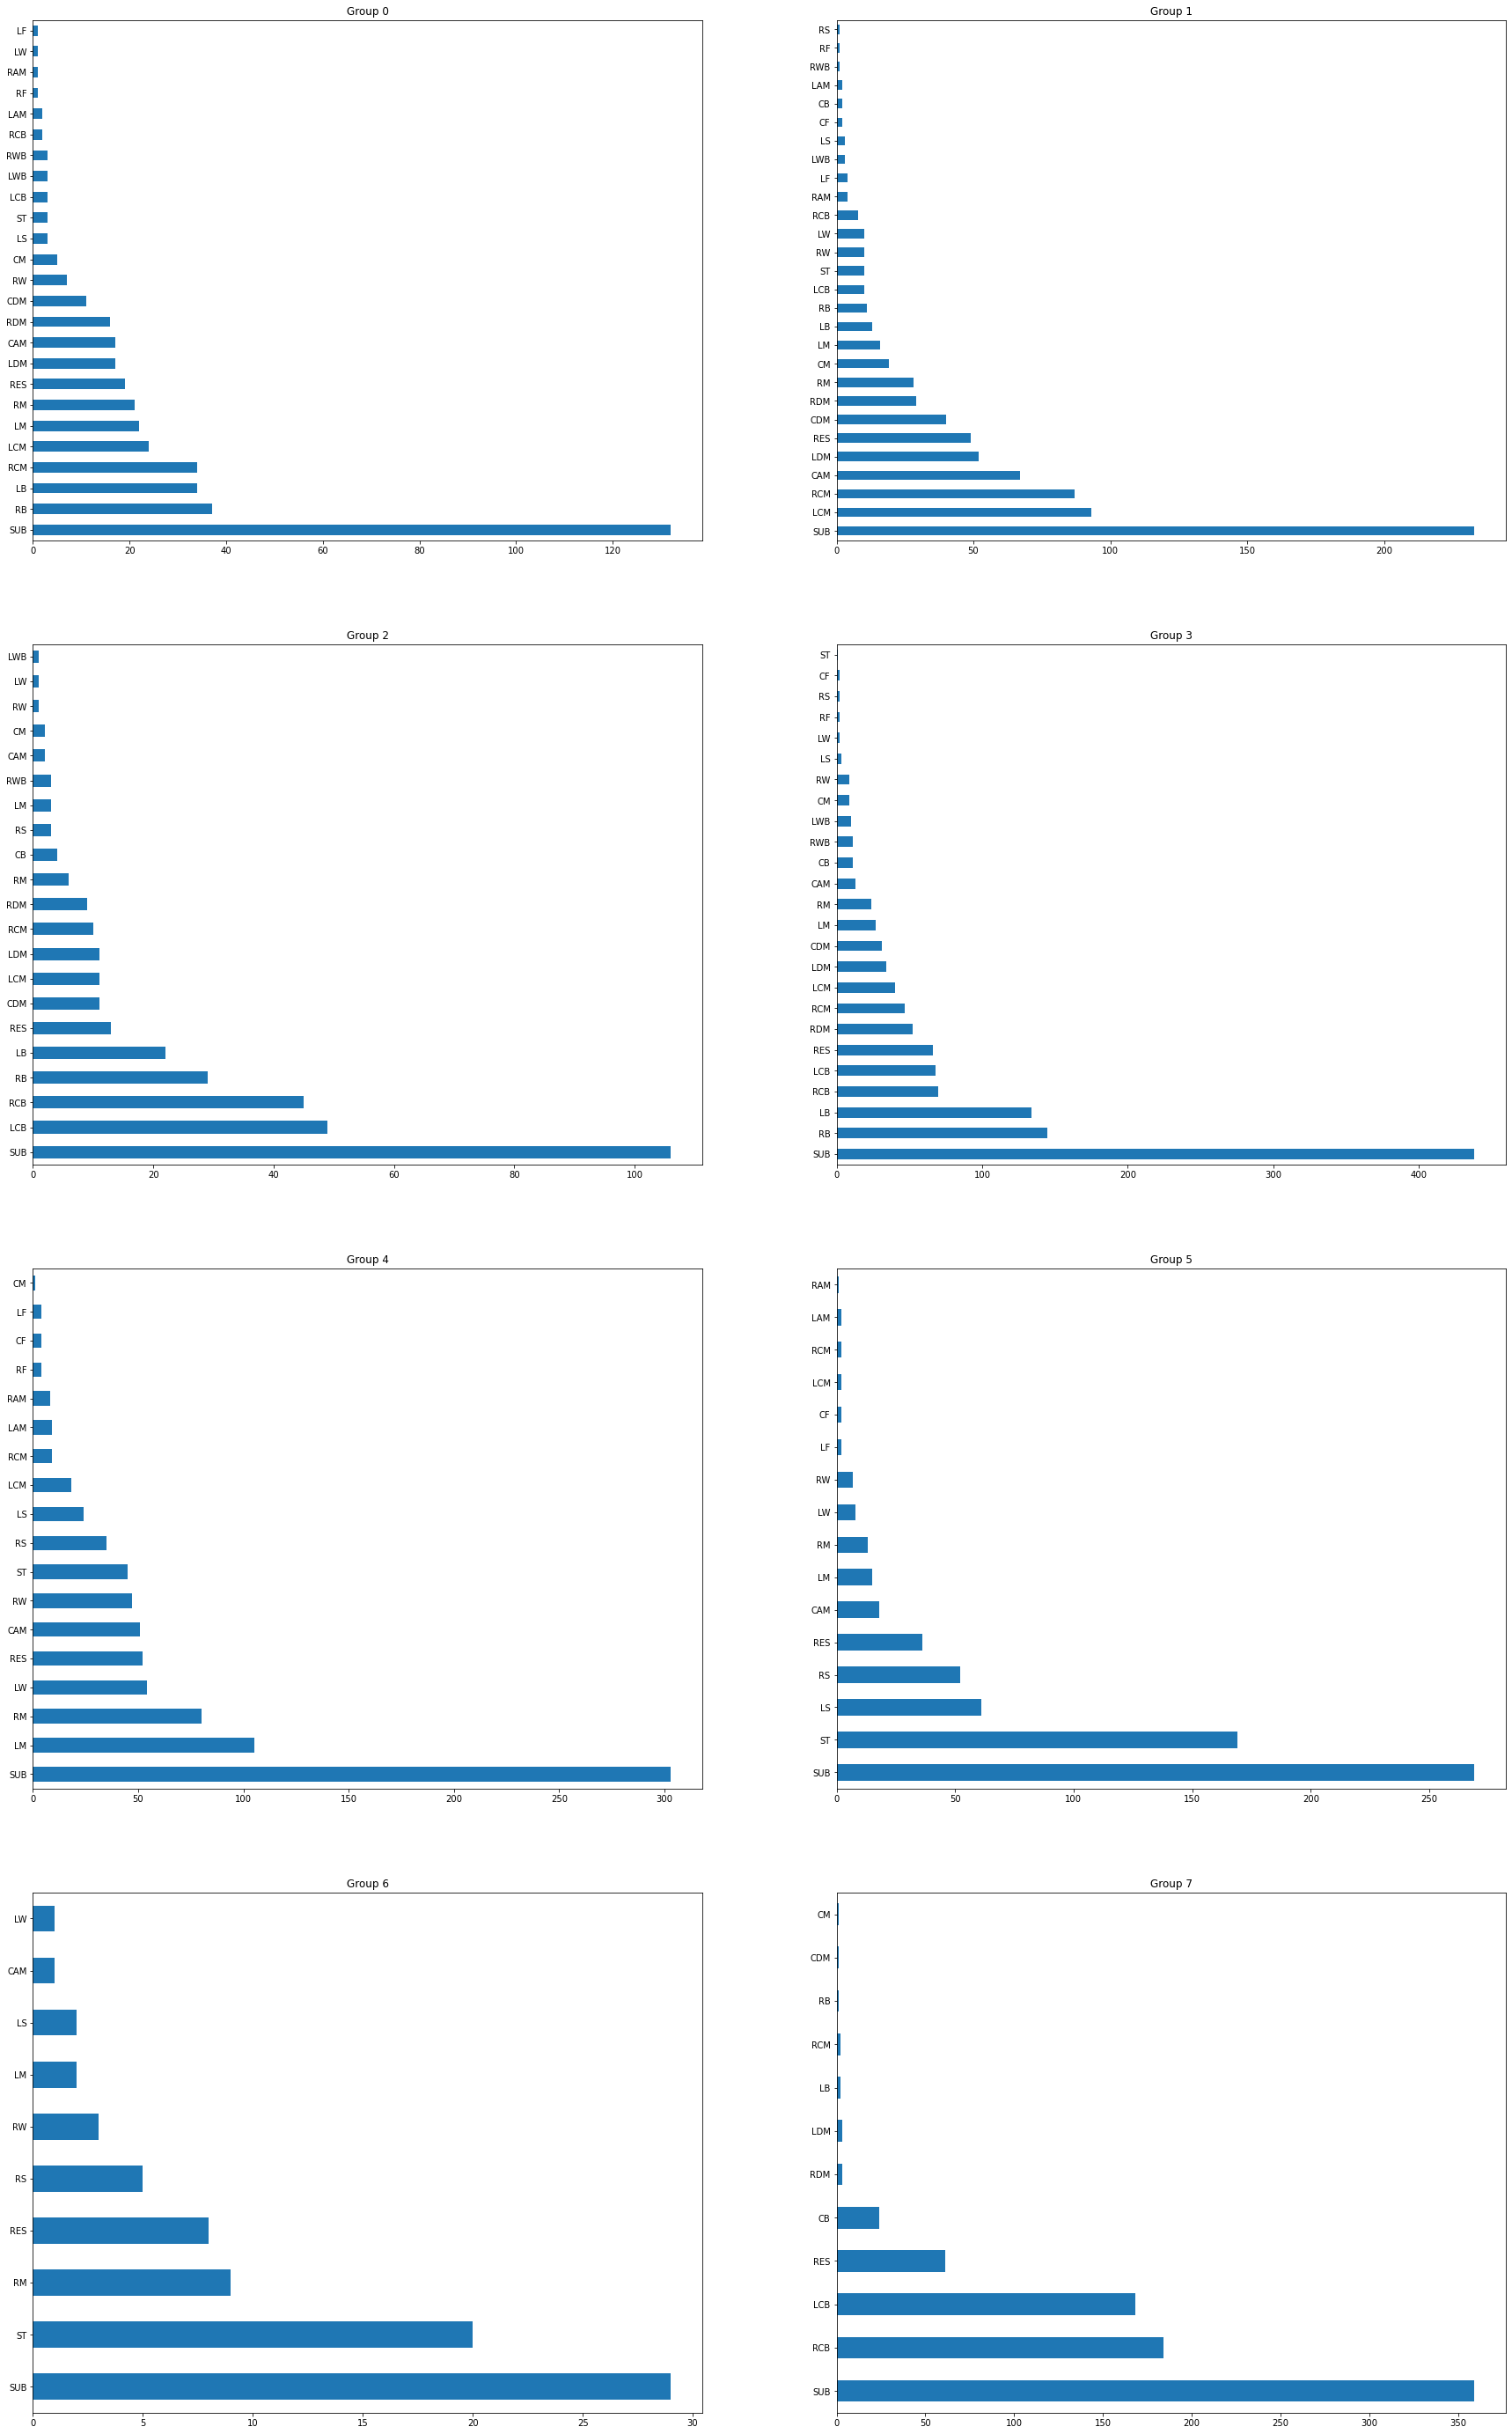

In [126]:
df_meanshift = df_n
df_meanshift['group_label'] = ms.labels_ 
column_name = 'team_position'
fig, axs = plt.subplots(4, 2, figsize=(30, 50), sharey=False)
get_colum_series_by_group(df_meanshift, column_name, 0).value_counts().plot(kind='barh', title='Group 0', ax=axs[0][0] )
get_colum_series_by_group(df_meanshift, column_name, 1).value_counts().plot(kind='barh', title='Group 1', ax=axs[0][1] )
get_colum_series_by_group(df_meanshift, column_name, 2).value_counts().plot(kind='barh', title='Group 2', ax=axs[1][0] )
get_colum_series_by_group(df_meanshift, column_name, 3).value_counts().plot(kind='barh', title='Group 3', ax=axs[1][1] )
get_colum_series_by_group(df_meanshift, column_name, 4).value_counts().plot(kind='barh', title='Group 4', ax=axs[2][0] )
get_colum_series_by_group(df_meanshift, column_name, 5).value_counts().plot(kind='barh', title='Group 5', ax=axs[2][1] )
get_colum_series_by_group(df_meanshift, column_name, 6).value_counts().plot(kind='barh', title='Group 6', ax=axs[3][0] )
get_colum_series_by_group(df_meanshift, column_name, 7).value_counts().plot(kind='barh', title='Group 7', ax=axs[3][1] )
